In [1]:
import pandas as pd

df = pd.read_csv("..\\data\\fraud.csv", index_col=0)

# Check your data and define X and y : What is X and what is y?
y = df["Class"].values
df = df.iloc[:, 1:]
X = df.drop(columns="Class").values
df[["Class"]].value_counts()

Class
0        21337
1          356
Name: count, dtype: int64

In [2]:
# perform train - test split. (40% as testing and 60% as training)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=1
)
# check the number of rows in the training and testing data
print("Number of rows in training data:", X_train.shape[0])
print("Number of rows in testing data:", X_test.shape[0])

Number of rows in training data: 13015
Number of rows in testing data: 8678


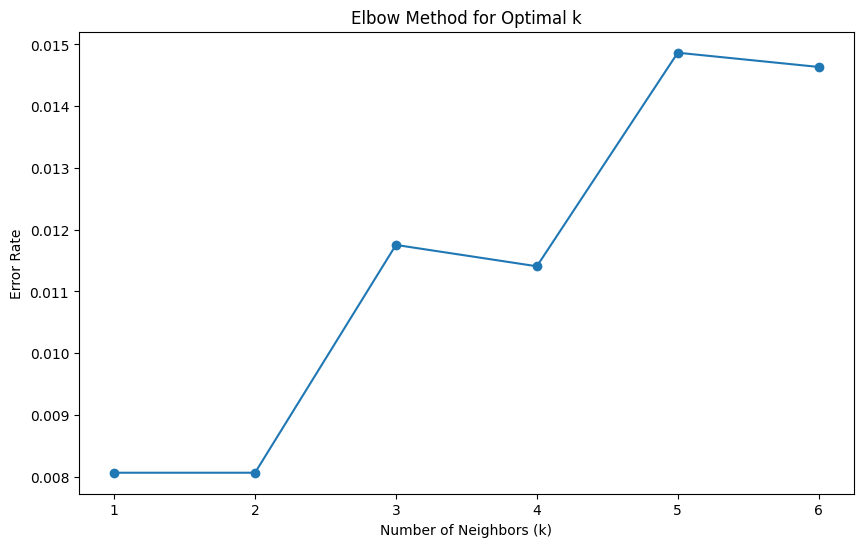

In [3]:
# --------------------------------------------------
## ----------- K-NN Classifier ------------------##
# --------------------------------------------------
from sklearn.preprocessing import StandardScaler

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

error_rates = []
n_range = range(1, 7)
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors=n, weights="distance")
    pipe = Pipeline(
        [("scaler", StandardScaler()), ("smote", SMOTE(random_state=1)), ("knn", knn)]
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    error = 1 - (y_pred == y_test).mean()
    error_rates.append(error)

plt.figure(figsize=(10, 6))
plt.plot(n_range, error_rates, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error Rate")
plt.title("Elbow Method for Optimal k")
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(weights='distance'))
])

param_grid = {
    "knn__n_neighbors": [2, 3, 4, 5]
}

grid = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best k:", grid.best_params_)
print("Best f1:", grid.best_score_)


Best k: {'knn__n_neighbors': 2}
Best f1: 0.7818427737933031


In [16]:
grid = GridSearchCV(pipeline, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best k:", grid.best_params_)
print("Best recall:", grid.best_score_)

Best k: {'knn__n_neighbors': 5}
Best recall: 0.8738648947951274


In [18]:
grid = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best k:", grid.best_params_)
print("Best roc-auc:", grid.best_score_)

Best k: {'knn__n_neighbors': 4}
Best roc-auc: 0.9427337877237811


In [19]:
knn_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Feature scaling is critical for KNN
        ("smote", SMOTE(random_state=42)),  # Balance the training data
        (
            "knn",
            KNeighborsClassifier(n_neighbors=2, weights="distance"),
        ),  # Distance-weighted KNN
    ]
)

knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])

[[8491   45]
 [  25  117]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8536
           1       0.72      0.82      0.77       142

    accuracy                           0.99      8678
   macro avg       0.86      0.91      0.88      8678
weighted avg       0.99      0.99      0.99      8678

0.919477325527674


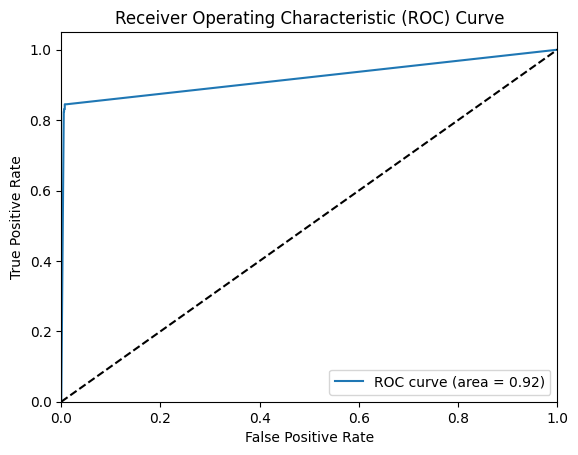

In [20]:
# --------------------------------------------------
## Model Evaluation ##
# --------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

ypred_test = knn_pipeline.predict(X_test)
mat_clf = confusion_matrix(y_test, ypred_test)
report_clf = classification_report(y_test, ypred_test)

print(mat_clf)
print(report_clf)

ypred_testP = knn_pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, ypred_testP[:, 1])
print(auc)


fpr, tpr, thresholds = roc_curve(y_test, ypred_testP[:, 1])
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [21]:
ypred_train = knn_pipeline.predict(X_train)
mat_clf = confusion_matrix(y_train, ypred_train)
report_clf = classification_report(y_train, ypred_train)

print(mat_clf)
print(report_clf)

ypred_trainP = knn_pipeline.predict_proba(X_train)
auc = roc_auc_score(y_train, ypred_trainP[:, 1])
print(auc)

[[12801     0]
 [    0   214]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       1.00      1.00      1.00       214

    accuracy                           1.00     13015
   macro avg       1.00      1.00      1.00     13015
weighted avg       1.00      1.00      1.00     13015

1.0


In [22]:
import pandas as pd

df1 = pd.DataFrame({"fpr": fpr, "tpr": tpr, "th": thresholds})
df1

fpr       tpr        th
0  0.000000  0.000000       inf
1  0.005037  0.823944  1.000000
2  0.005623  0.823944  0.498217
3  0.005623  0.830986  0.498200
4  0.007029  0.830986  0.492175
5  0.007029  0.845070  0.490082
6  0.010895  0.845070  0.236963
7  1.000000  1.000000  0.000000